<a href="https://colab.research.google.com/github/gaveter/Project_cs/blob/master/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Project 2019-20
**Author**: Matteo Gaverini

## Load libraries

In [3]:
import pandas as pd
from datetime import datetime, timedelta
import re
import numpy as np
from pandas.tseries.offsets import BDay
import matplotlib.pyplot as plt
import itertools
import functools
import calendar
from collections import defaultdict

In [4]:
!pip install ipython-autotime  #necessario per stampare il tempo di esecuzione di ogni chunk
%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1831 sha256=59cd83fa88d2eebb6bff16fb97ebd5dd7680f937bdbefc8a28e28e2c1dbcddcb
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


## Task1
- Normalize the loan_lenders table. In the normalized table, each row must have one loan_id and one lender.

### Load csv (loans_lenders)

In [5]:
loans_lender = pd.read_csv('/content/drive/My Drive/Foundation of computer science/additional-kiva-snapshot/loans_lenders.csv')

time: 6.07 s


_Overview_

In [6]:
loans_lender.dtypes

loan_id     int64
lenders    object
dtype: object

time: 10.2 ms


In [7]:
print("Number rows: "+str(len(loans_lender)))
loans_lender.head()

Number rows: 1387432


,loan_id,lenders
0,483693,"muc888, sam4326, camaran3922, lachheb1865, reb..."
1,483738,"muc888, nora3555, williammanashi, barbara5610,..."
2,485000,"muc888, terrystl, richardandsusan8352, sherri4..."
3,486087,"muc888, james5068, rudi5955, daniel9859, don92..."
4,534428,"muc888, niki3008, teresa9174, mike4896, david7..."


time: 15.4 ms


### Split each lender for each loan

In [8]:
loans_lender["lenders"]=loans_lender["lenders"].str.split(', ') #creazione lista per ogni riga
loans_lender_norm=loans_lender.explode('lenders') #trasformazione ogni elemento della lista come una riga

time: 19.5 s


In [9]:
loans_lender_norm=loans_lender_norm.reset_index(drop=True)

time: 526 ms


### _Result_

In [10]:
loans_lender_norm.head()

,loan_id,lenders
0,483693,muc888
1,483693,sam4326
2,483693,camaran3922
3,483693,lachheb1865
4,483693,rebecca3499


time: 9.81 ms


## Task2
- For each loan, add a column duration corresponding to the number of days between the disburse time and the planned expiration time. If any of those two dates is missing, also the duration must be missing.

### Load csv (loans)

In [11]:
loan = pd.read_csv('/content/drive/My Drive/Foundation of computer science/additional-kiva-snapshot/loans.csv')

time: 39.9 s


_Overview_

In [12]:
loan.dtypes

loan_id                              int64
loan_name                           object
original_language                   object
description                         object
description_translated              object
funded_amount                      float64
loan_amount                        float64
status                              object
activity_name                       object
sector_name                         object
loan_use                            object
country_code                        object
country_name                        object
town_name                           object
currency_policy                     object
currency_exchange_coverage_rate    float64
currency                            object
partner_id                         float64
posted_time                         object
planned_expiration_time             object
disburse_time                       object
raised_time                         object
lender_term                        float64
num_lenders

time: 4.22 ms


In [13]:
print('Number rows: '+str(len(loan)))
loan.head()

Number rows: 1419607


,loan_id,loan_name,original_language,description,description_translated,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,currency_policy,currency_exchange_coverage_rate,currency,partner_id,posted_time,planned_expiration_time,disburse_time,raised_time,lender_term,num_lenders_total,num_journal_entries,num_bulk_entries,tags,borrower_genders,borrower_pictured,repayment_interval,distribution_model
0,657307,Aivy,English,"Aivy, 21 years of age, is single and lives in ...",NaN,125.0,125.0,funded,General Store,Retail,to buy additional inventories for her sari-sa...,PH,Philippines,Ozamiz - Ozamiz City,shared,0.1,PHP,126.0,2014-01-15 02:23:45.000 +0000,2014-02-14 03:30:06.000 +0000,2013-12-22 08:00:00.000 +0000,2014-01-15 04:48:22.000 +0000,7.0,3,2,1,NaN,female,true,irregular,field_partner
1,657259,Idalia Marizza,Spanish,"Doña Idalia, esta casada, tiene 57 años de eda...","Idalia, 57, is married and lives with her husb...",400.0,400.0,funded,Used Clothing,Clothing,"To buy American clothing such as blouses, shir...",HN,Honduras,"La Lopez, Choloma",shared,0.1,HNL,201.0,2014-01-14 20:23:20.000 +0000,2014-03-26 22:25:07.000 +0000,2013-12-20 08:00:00.000 +0000,2014-02-25 06:42:06.000 +0000,8.0,11,2,1,NaN,female,true,monthly,field_partner
2,658010,Aasia,English,Aasia is a 45-year-old married lady and she ha...,NaN,400.0,400.0,funded,General Store,Retail,"to buy stock of rice, sugar and flour",PK,Pakistan,Lala Musa,shared,0.1,PKR,245.0,2014-01-16 11:32:58.000 +0000,2014-02-15 21:10:05.000 +0000,2014-01-09 08:00:00.000 +0000,2014-01-24 23:06:18.000 +0000,14.0,16,2,1,"#Woman Owned Biz, #Supporting Family, user_fav...",female,true,monthly,field_partner
3,659347,Gulmira,Russian,"Гулмире 36 лет, замужем, вместе с супругом вос...",Gulmira is 36 years old and married. She and ...,625.0,625.0,funded,Farming,Agriculture,"to buy cucumber and tomato seeds, as well as f...",KG,Kyrgyzstan,"Aravan village, Osh region",shared,0.1,KGS,171.0,2014-01-20 09:59:48.000 +0000,2014-02-21 03:10:02.000 +0000,2014-01-17 08:00:00.000 +0000,2014-01-22 05:29:28.000 +0000,14.0,21,2,1,user_favorite,female,true,monthly,field_partner
4,656933,Ricky\t,English,Ricky is a farmer who currently cultivates his...,NaN,425.0,425.0,funded,Farming,Agriculture,to buy organic fertilizer and agrochemical pr...,PH,Philippines,"Baleleng, Sto. Thomas, Isabela",shared,0.1,PHP,123.0,2014-01-14 05:46:21.000 +0000,2014-02-13 06:10:02.000 +0000,2013-12-17 08:00:00.000 +0000,2014-01-14 17:29:27.000 +0000,7.0,15,2,1,"#Animals, #Eco-friendly, #Sustainable Ag",male,true,bullet,field_partner


time: 61.7 ms


### Check missing values

In [14]:
missing_loan_expiration = pd.isnull(loan[['planned_expiration_time']])
missing_loan_disburse = pd.isnull(loan[['disburse_time']])

time: 158 ms


In [15]:
missing_loan_index_e = missing_loan_expiration[missing_loan_expiration['planned_expiration_time']==True].index
missing_loan_index_d = missing_loan_disburse[missing_loan_disburse['disburse_time']==True].index

time: 164 ms


In [16]:
print('Number rows missing values planned_expiration_time: '+str(len(missing_loan_index_e)))
print('Number rows missing values disburse_time: '+str(len(missing_loan_index_d)))

Number rows missing values planned_expiration_time: 371834
Number rows missing values disburse_time: 2813
time: 1.72 ms


In [17]:
missing_loan_index = missing_loan_index_e.union(missing_loan_index_d) #union indici nan disburse e nan expiration

time: 7.11 ms


In [18]:
missing = loan.loc[missing_loan_index]
print('Number missing: '+str(len(missing)))
print('Ratio missing: '+str(len(missing) / len(loan)))

Number missing: 374645
Ratio missing: 0.26390754624343216
time: 378 ms


### Conversion attributes _planned_expiration_time_, _disburse_time_ to _Datetime_

In [19]:
loan['planned_expiration_time'] = pd.to_datetime(loan.loc[:,'planned_expiration_time'])
loan['disburse_time'] = pd.to_datetime(loan.loc[:,'disburse_time'])

time: 1.71 s


### Compute difference between _planned_expiration_time_ and _disburse_time_

In [20]:
loan['duration'] = loan['planned_expiration_time']- loan['disburse_time'] #si ottiene oggetto timedelta

time: 33.7 ms


In [ ]:
loan['duration'] = loan.apply(lambda x: x['duration'].days,axis=1)

### _Result_

In [ ]:
loan.head()[['planned_expiration_time','disburse_time','duration']]

In [ ]:
loan.loc[missing_loan_index][['planned_expiration_time','disburse_time','duration']]

## Task 3
- Find the lenders that have funded at least twice

In [ ]:
numberfunded_lenders = loans_lender_norm.groupby('lenders')['loan_id'].count()
numberfunded_lenders = pd.DataFrame(numberfunded_lenders).reset_index(drop=False)

### Apply constraint after group by 

In [ ]:
numberfunded_lenders.rename(columns={'loan_id': 'count'},inplace=True)
numberfunded_lenders = numberfunded_lenders[numberfunded_lenders['count']>=2]

### _Result_

In [ ]:
numberfunded_lenders.head()

## Task 4
- For each country, compute how many loans have involved that country as borrowers.

### Check missing values

In [ ]:
missing_name = pd.isnull(loan[['country_name']])
missing_name[missing_name['country_name']==True]

,country_name


time: 79.9 ms


In [ ]:
missing_code = pd.isnull(loan[['country_code']])
index_code = missing_code[missing_code['country_code']==True].index
index_code

Int64Index([82889, 156970, 598087, 684876, 971827, 1134818, 1214923, 1281022,
            1415763],
           dtype='int64')

time: 79.3 ms


### Replace missing values with manual imputation

In [ ]:
loan.loc[index_code]['country_name']

82889      Namibia
156970     Namibia
598087     Namibia
684876     Namibia
971827     Namibia
1134818    Namibia
1214923    Namibia
1281022    Namibia
1415763    Namibia
Name: country_name, dtype: object

time: 7.28 ms


In [ ]:
loan['country_code'] = loan['country_code'].fillna('NA') #imputazione manuale (valore ottenuto da https://en.wikipedia.org/wiki/ISO_3166-1_alpha-2) 

time: 133 ms


### Compute calculation

In [ ]:
country_numberLoan = loan.groupby('country_code')['loan_id'].count()
country_numberLoan = pd.DataFrame(country_numberLoan).reset_index(drop=False)
country_numberLoan.rename(columns={'loan_id':'count'},inplace=True)

time: 88 ms


### _Result_

In [ ]:
country_numberLoan.head()

,country_code,count
0,AF,2337
1,AL,3075
2,AM,13952
3,AZ,10172
4,BA,608


time: 10.3 ms


## Task 5
- For each country, compute the overall amount of money borrowed.

In [ ]:
check = loan[['country_code','currency','loan_id']]
pd.DataFrame(check.groupby(['country_code','currency'])['loan_id'].count()) #motivo per cui non è stata considerata la valuta di ogni prestito

loan_id
country_code currency         
AF           AFN          1958
             USD           379
AL           ALL          3072
             EUR             2
             USD             1
...                        ...
ZM           USD            22
             ZMK            51
             ZMW          1204
ZW           USD          5511
             ZWD             2

[163 rows x 1 columns]

time: 241 ms


In [ ]:
loan_simplified = loan[['loan_id','country_code','disburse_time','planned_expiration_time',
                                      'num_lenders_total','loan_amount']] #feature essenziali per risolvere gli altri task

time: 74.9 ms


### Check missing values

In [ ]:
missing = pd.isnull(loan_simplified[['loan_amount']])
missing[missing['loan_amount']==True]

,loan_amount


time: 724 ms


### Compute calculation

In [ ]:
country_amount_loan = loan_simplified.groupby('country_code')['loan_amount'].sum().reset_index()

time: 103 ms


### _Result_

In [ ]:
country_amount_loan.head()

,country_code,loan_amount
0,AF,1967950.0
1,AL,4307350.0
2,AM,22950475.0
3,AZ,14784625.0
4,BA,477250.0


time: 10.4 ms


## Task 6
- Like the previous point, but expressed as a percentage of the overall amount lent.

In [ ]:
country_amount_loan_perc=country_amount_loan
country_amount_loan.rename(columns={'loan_amount':'borrowed'},inplace=True)

time: 2 ms


### Compute ratio between total country and overall amount

In [ ]:
total=country_amount_loan_perc['borrowed'].sum()
country_amount_loan_perc['percentage']=round(country_amount_loan_perc['borrowed']/total*100,2)

time: 24.4 ms


### _Result_

In [ ]:
country_amount_loan_perc[['country_code','percentage']].head()

,country_code,percentage
0,AF,0.17
1,AL,0.36
2,AM,1.94
3,AZ,1.25
4,BA,0.04


time: 14.3 ms


## Task 7
- Like the three previous points, but split for each year (with respect to disburse time).

### Check missing values

In [ ]:
loan_simplified.loc[missing_loan_index_d]

,loan_id,country_code,disburse_time,planned_expiration_time,num_lenders_total,loan_amount
31106,1379508,US,NaT,2017-12-06 16:41:36+00:00,2,1000.0
31107,1428617,US,NaT,2018-01-25 19:25:55+00:00,0,10000.0
31178,1135319,US,NaT,2016-09-02 20:27:46+00:00,2,500.0
32151,1279252,US,NaT,2017-05-04 23:31:00+00:00,0,1000.0
32152,1433349,US,NaT,2018-01-04 18:49:43+00:00,0,8000.0
...,...,...,...,...,...,...
1419522,1082442,US,NaT,2014-10-14 16:05:01+00:00,37,3000.0
1419524,1227124,US,NaT,2017-02-09 23:07:54+00:00,9,10000.0
1419525,1089430,KE,NaT,2015-09-21 08:06:19+00:00,3,225.0
1419538,1235452,US,NaT,2017-02-25 20:21:21+00:00,3,3000.0


time: 29.5 ms


### Get year from _disburse_time_ for each loan

In [ ]:
loan_simplified=loan_simplified.copy()
loan_simplified['year_disburse'] = loan_simplified.apply(lambda x: x['disburse_time'].year,axis=1)

time: 2min 23s


In [ ]:
year_nan = pd.isnull(loan_simplified['year_disburse'])
year_nan_index = year_nan[year_nan==True].index

loan_year = loan_simplified.drop(index=year_nan_index) #non considero tuple che hanno missing values in 'disburse_time'

time: 109 ms


In [ ]:
loan_year['year_disburse']=loan_year['year_disburse'].astype(int)
loan_year = loan_year.copy()

time: 66.9 ms


### Point 4 (how many loans)

In [ ]:
loan_state_year = loan_year.groupby(['country_code','year_disburse'])['loan_id'].count()
loan_state_year = pd.DataFrame(loan_state_year)

time: 122 ms


In [ ]:
loan_state_year.rename(columns={'loan_id':'count'},inplace=True)

time: 1.97 ms


#### _Result_

In [ ]:
loan_state_year.head()

count
country_code year_disburse       
AF           2007             408
             2008             370
             2009             678
             2010             632
             2011             247

time: 10.3 ms


### Point 5 (amount money borrowed)

In [ ]:
amount_state_year = loan_year.groupby(['country_code','year_disburse'])['loan_amount'].sum()
amount_state_year = pd.DataFrame(amount_state_year)

time: 120 ms


#### _Result_

In [ ]:
amount_state_year.head()

loan_amount
country_code year_disburse             
AF           2007              194975.0
             2008              365375.0
             2009              585125.0
             2010              563350.0
             2011              245125.0

time: 10.5 ms


### Point 6 (amount money percentage)

In [ ]:
amount_state_year.reset_index(level=[0],inplace=True) #conversione multiindex in indice singolo

time: 4.19 ms


In [ ]:
total_year = loan_year.groupby('year_disburse')['loan_amount'].sum() #per ogni anno denaro totale prestiti
total_year = pd.DataFrame(total_year)

time: 22.7 ms


In [ ]:
total_year

,loan_amount
year_disburse,
2005,102850.0
2006,1376575.0
2007,15446525.0
2008,39423050.0
2009,59689475.0
2010,72609150.0
2011,93699300.0
2012,119977575.0
2013,132043925.0


time: 9 ms


In [ ]:
amount_state_year_perc = pd.merge(amount_state_year,total_year,on='year_disburse',how='inner')
amount_state_year_perc.rename(columns={'loan_amount_x': 'loan_amount',
                    'loan_amount_y': 'total'}, inplace=True)

time: 10.3 ms


In [ ]:
amount_state_year_perc

,country_code,loan_amount,total
year_disburse,,,
2007,AF,194975.0,15446525.0
2007,AZ,1892775.0,15446525.0
2007,BG,263050.0,15446525.0
2007,BO,304700.0,15446525.0
2007,CD,30600.0,15446525.0
...,...,...,...
2018,TH,26500.0,990025.0
2018,TZ,14300.0,990025.0
2018,UG,21750.0,990025.0


time: 14.7 ms


In [ ]:
amount_state_year_perc.reset_index(inplace=True)
amount_state_year_perc.sort_values(by=['country_code','year_disburse'],ascending=True,inplace=True)

time: 5.71 ms


In [ ]:
amount_state_year_perc

,year_disburse,country_code,loan_amount,total
0,2007,AF,194975.0,15446525.0
37,2008,AF,365375.0,39423050.0
82,2009,AF,585125.0,59689475.0
132,2010,AF,563350.0,72609150.0
186,2011,AF,245125.0,93699300.0
...,...,...,...,...
533,2013,ZW,678525.0,132043925.0
611,2014,ZW,1311575.0,152270425.0
321,2015,ZW,723625.0,155835650.0
395,2016,ZW,788600.0,160978375.0


time: 19.1 ms


In [ ]:
amount_state_year_perc.set_index(['country_code','year_disburse'],inplace=True) #creazione multiindex
amount_state_year_perc['percentage'] = round(amount_state_year_perc['loan_amount'] / amount_state_year_perc['total']*100,3)

time: 9.52 ms


In [ ]:
amount_state_year_perc

loan_amount        total  percentage
country_code year_disburse                                      
AF           2007              194975.0   15446525.0       1.262
             2008              365375.0   39423050.0       0.927
             2009              585125.0   59689475.0       0.980
             2010              563350.0   72609150.0       0.776
             2011              245125.0   93699300.0       0.262
...                                 ...          ...         ...
ZW           2013              678525.0  132043925.0       0.514
             2014             1311575.0  152270425.0       0.861
             2015              723625.0  155835650.0       0.464
             2016              788600.0  160978375.0       0.490
             2017             1237600.0  166053650.0       0.745

[748 rows x 3 columns]

time: 22 ms


In [ ]:
amount_state_year_perc.drop(columns='total',inplace=True)
amount_state_year_perc.rename(columns={'loan_amount':'borrowed'},inplace=True)

time: 4.04 ms


#### _Result_

In [ ]:
amount_state_year_perc[['percentage']].head()

percentage
country_code year_disburse            
AF           2007                1.262
             2008                0.927
             2009                0.980
             2010                0.776
             2011                0.262

time: 11.6 ms


## Task 8
- For each lender, compute the overall amount of money lent. For each loan that has more than one lender, you must assume that all lenders contributed the same amount.

In [ ]:
number_loans_lender_norm=loans_lender_norm.groupby('loan_id')['lenders'].count()
number_loans_lender_norm=pd.DataFrame(number_loans_lender_norm).reset_index(level=0) #per ogni loan numero lenders

time: 2.3 s


In [ ]:
number_loans_lender_norm.head()

,loan_id,lenders
0,84,3
1,85,2
2,86,3
3,88,3
4,89,4


time: 8.89 ms


### Get number lenders for each loan

In [ ]:
loans_lender_amount = pd.merge(loan_simplified,number_loans_lender_norm,how="inner",on="loan_id")
loans_lender_amount= loans_lender_amount[['loan_id','num_lenders_total','lenders','loan_amount']]

time: 495 ms


In [ ]:
correct = loans_lender_amount[loans_lender_amount['num_lenders_total']==loans_lender_amount['lenders']]
wrong = loans_lender_amount[loans_lender_amount['num_lenders_total']!=loans_lender_amount['lenders']]

time: 52.7 ms


In [ ]:
print("Correct info: "+str(len(correct)/len(loans_lender_amount)))
print("Error info: "+str(len(wrong)/len(loans_lender_amount)))

Correct info: 0.1917209397532701
Error info: 0.8082790602467299
time: 1.63 ms


### Fixed count lenders for each loan

In [ ]:
loans_lender_amount.drop(columns='num_lenders_total',inplace=True)

time: 12.7 ms


In [ ]:
loans_lender_amount.head()

,loan_id,lenders,loan_amount
0,657307,3,125.0
1,657259,7,400.0
2,658010,14,400.0
3,659347,17,625.0
4,656933,14,425.0


time: 11.7 ms


### Compute contribution lenders for each loan

In [ ]:
loans_lender_amount['amount']=round(loans_lender_amount['loan_amount']/loans_lender_amount['lenders'],2)

time: 16.2 ms


In [ ]:
loans_lender_amount.head()

,loan_id,lenders,loan_amount,amount
0,657307,3,125.0,41.67
1,657259,7,400.0,57.14
2,658010,14,400.0,28.57
3,659347,17,625.0,36.76
4,656933,14,425.0,30.36


time: 13 ms


In [ ]:
amount_loan_lender = pd.merge(loans_lender_norm,loans_lender_amount,how="inner",on='loan_id')
amount_loan_lender.drop(columns=['loan_amount','lenders_y'],inplace=True)
amount_loan_lender.rename(columns={'lenders_x':'lenders'},inplace=True)

time: 5.32 s


In [ ]:
amount_loan_lender.head()

,loan_id,lenders,amount
0,483693,muc888,30.62
1,483693,sam4326,30.62
2,483693,camaran3922,30.62
3,483693,lachheb1865,30.62
4,483693,rebecca3499,30.62


time: 11.4 ms


In [ ]:
amount_lender = amount_loan_lender.groupby('lenders')['amount'].sum()
amount_lender = pd.DataFrame(amount_lender).reset_index(level=0)

time: 11.9 s


### _Result_

In [ ]:
amount_lender.head()

,lenders,amount
0,000,1764.26
1,00000,1380.68
2,0002,2472.54
3,00mike00,52.63
4,0101craign0101,2623.50


time: 10.2 ms


## Task 9
- For each country, compute the difference between the overall amount of money lent and the overall amount of money borrowed. Since the country of the lender is often unknown, you can assume that the true distribution among the countries is the same as the one computed from the rows where the country is known.

### Load csv (lenders)

In [ ]:
lenders = pd.read_csv('/content/drive/My Drive/Foundation of computer science/additional-kiva-snapshot/lenders.csv')

time: 3.83 s


_Overview_

In [ ]:
lenders.dtypes

permanent_name        object
display_name          object
city                  object
state                 object
country_code          object
member_since           int64
occupation            object
loan_because          object
loan_purchase_num    float64
invited_by            object
num_invited            int64
dtype: object

time: 4.45 ms


In [ ]:
print('Number rows: '+str(len(lenders)))
lenders.head()

Number rows: 2349174


,permanent_name,display_name,city,state,country_code,member_since,occupation,loan_because,loan_purchase_num,invited_by,num_invited
0,qian3013,Qian,NaN,NaN,NaN,1461300457,NaN,NaN,1.0,NaN,0
1,reena6733,Reena,NaN,NaN,NaN,1461300634,NaN,NaN,9.0,NaN,0
2,mai5982,Mai,NaN,NaN,NaN,1461300853,NaN,NaN,NaN,NaN,0
3,andrew86079135,Andrew,NaN,NaN,NaN,1461301091,NaN,NaN,5.0,Peter Tan,0
4,nguyen6962,Nguyen,NaN,NaN,NaN,1461301154,NaN,NaN,NaN,NaN,0


time: 26 ms


In [ ]:
lenders['state'].unique() #motivo per cui si sceglie country_code come id country

array([nan, 'NSW', 'FL', ..., 'Memphis, TN', 'West Parade', 'Cymru Wales'],
      dtype=object)

time: 117 ms


In [ ]:
lenders = lenders[['permanent_name','country_code']]

time: 45.4 ms


In [ ]:
unknown_lenders = lenders[lenders['country_code'].isnull()]
tot = len(lenders)

time: 152 ms


In [ ]:
print("Country lenders unknown: "+str(len(unknown_lenders)/tot))

Country lenders unknown: 0.620913989342637
time: 1.01 ms


In [ ]:
lenders.drop(index=unknown_lenders.index,inplace=True)
lenders_country = lenders

time: 417 ms


### Compute distribution country lenders known

In [ ]:
dist = lenders_country['country_code'].value_counts(normalize=True) #ritorna frequenza relativa
lenders_country_dist = pd.DataFrame(dist).reset_index(drop=False)
lenders_country_dist.rename(columns={'index':'country_code',
                                     'country_code':'distribution'},inplace=True)

time: 97 ms


In [ ]:
lenders_country_dist['distribution_100'] = round(lenders_country_dist['distribution'] * 100,2)

time: 2.6 ms


### Distribution country lenders known



In [ ]:
dist

US    0.664330
CA    0.076325
GB    0.043097
AU    0.041664
DE    0.017975
        ...   
IO    0.000001
GW    0.000001
KM    0.000001
TF    0.000001
MS    0.000001
Name: country_code, Length: 234, dtype: float64

time: 4.11 ms


Text(0, 0.5, 'percentage(%)')

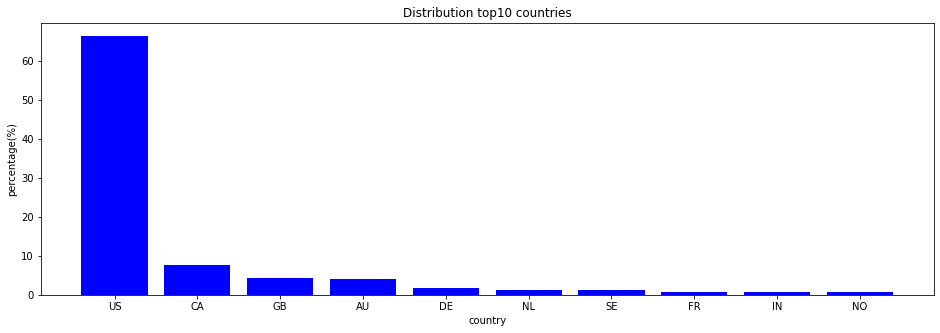

time: 212 ms


In [ ]:
dist_focus = lenders_country_dist.head(10)
fig = plt.figure(figsize=(16,5))
plt.bar(dist_focus['country_code'],dist_focus['distribution_100'],color='blue')
plt.title('Distribution top10 countries')
plt.xlabel('country')
plt.ylabel('percentage(%)')

### Replace NAN according distribution computed before

In [ ]:
unknown_lenders = unknown_lenders.copy()
unknown_lenders['country_code'] = np.random.choice(dist.index, size = len(unknown_lenders), p = dist.values)

time: 111 ms


### Compare two distributions

In [ ]:
dist_nan = unknown_lenders['country_code'].value_counts(normalize=True)
unknown_code_dist = pd.DataFrame(dist_nan).reset_index(drop=False)
unknown_code_dist.rename(columns={'index':'country_code',
                                     'country_code':'distribution'},inplace=True)
unknown_code_dist['distribution_unknown'] = round(unknown_code_dist['distribution']*100,2)

time: 133 ms


In [ ]:
compare_dist = pd.merge(lenders_country_dist,unknown_code_dist,how='inner',on='country_code')
compare_dist.drop(columns=['distribution_x','distribution_y'],inplace=True)

time: 8.5 ms


#### Barchart compare distribution (top10)

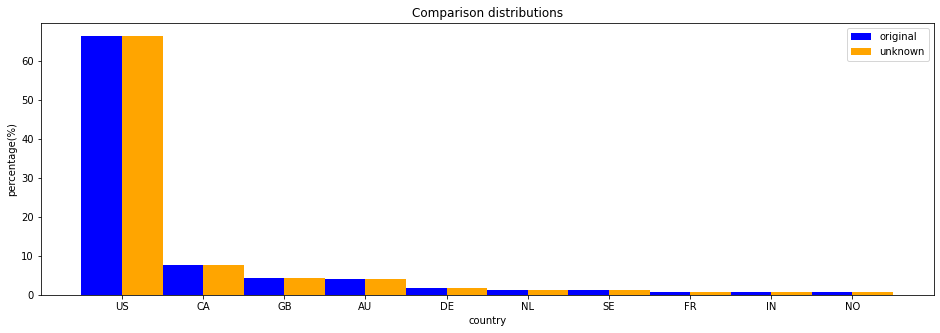

time: 247 ms


In [ ]:
compare_dist = compare_dist.head(10)
country = compare_dist['country_code']

x = np.arange(len(compare_dist))
fig, ax = plt.subplots(figsize=(16,5))
bar_width = 0.5

ax.bar(x-bar_width/2,compare_dist['distribution_100'],width=bar_width,color='blue',label='original')
ax.bar(x+bar_width/2,compare_dist['distribution_unknown'],width=bar_width,color='orange',label='unknown')
plt.title('Comparison distributions')
ax.set_xticks(x)
ax.set_xticklabels(country)
plt.xlabel('country')
plt.ylabel('percentage(%)')
plt.legend()

In [ ]:
lenders_country = pd.concat([lenders_country,unknown_lenders],axis=0) #per ogni lender è associata una nazione

time: 48.8 ms


In [ ]:
lenders_country.rename(columns={'permanent_name':'lenders'},inplace=True)

time: 62.3 ms


In [ ]:
lenders_country

,lenders,country_code
16,naresh2074,US
31,christina27976796,US
37,vikas1098,IN
39,qian1385,US
42,xigg8769,US
...,...,...
2349167,todd5695,CA
2349168,kate40761039,US
2349169,janet7309,US
2349170,pj4198,US


time: 13.6 ms


### Get amount for each lender and his country

In [ ]:
amount_lender_country = pd.merge(amount_lender,lenders_country,how='inner',on='lenders')

time: 3.9 s


In [ ]:
amount_lender_country

,lenders,amount,country_code
0,000,1764.26,US
1,00000,1380.68,DE
2,0002,2472.54,US
3,00mike00,52.63,US
4,0101craign0101,2623.50,US
...,...,...,...
1383794,zzmcfate,66113.04,US
1383795,zzpaghetti9994,51.02,US
1383796,zzrvmf8538,576.97,PE
1383797,zzzsai,267.67,US


time: 20.3 ms


In [ ]:
country_amount_lent = amount_lender_country.groupby('country_code')['amount'].sum()
country_amount_lent = pd.DataFrame(country_amount_lent).reset_index(level=0)

time: 359 ms


In [ ]:
country_amount_lent.rename(columns={'amount':'lent'},inplace=True)

time: 2.16 ms


In [ ]:
len(country_amount_lent), len(country_amount_loan_perc)

(232, 96)

time: 2.55 ms


In [ ]:
lent = country_amount_lent['country_code'].values
borrowed = country_amount_loan_perc['country_code'].values

set(lent) - set(borrowed)

{'AD',
 'AE',
 'AG',
 'AI',
 'AN',
 'AO',
 'AQ',
 'AR',
 'AS',
 'AT',
 'AU',
 'AW',
 'BB',
 'BD',
 'BE',
 'BH',
 'BM',
 'BN',
 'BS',
 'BV',
 'BY',
 'CH',
 'CK',
 'CS',
 'CU',
 'CV',
 'CX',
 'CY',
 'CZ',
 'DE',
 'DJ',
 'DK',
 'DM',
 'DZ',
 'EE',
 'EH',
 'ER',
 'ES',
 'ET',
 'FI',
 'FJ',
 'FK',
 'FM',
 'FO',
 'FR',
 'GA',
 'GB',
 'GD',
 'GF',
 'GI',
 'GL',
 'GM',
 'GN',
 'GP',
 'GR',
 'GS',
 'GY',
 'HK',
 'HR',
 'HU',
 'IE',
 'IO',
 'IR',
 'IS',
 'IT',
 'JM',
 'JP',
 'KM',
 'KN',
 'KP',
 'KR',
 'KW',
 'KY',
 'KZ',
 'LC',
 'LI',
 'LT',
 'LU',
 'LV',
 'LY',
 'MA',
 'MC',
 'ME',
 'MH',
 'MK',
 'MO',
 'MP',
 'MQ',
 'MS',
 'MT',
 'MU',
 'MV',
 'MY',
 'NC',
 'NE',
 'NF',
 'NL',
 'NO',
 'NZ',
 'OM',
 'PF',
 'PL',
 'PN',
 'PT',
 'PW',
 'QA',
 'RE',
 'RO',
 'RS',
 'RU',
 'SA',
 'SC',
 'SD',
 'SE',
 'SG',
 'SH',
 'SI',
 'SJ',
 'SK',
 'SM',
 'SY',
 'SZ',
 'TC',
 'TF',
 'TK',
 'TM',
 'TN',
 'TO',
 'TT',
 'TV',
 'TW',
 'UM',
 'UZ',
 'VA',
 'VE',
 'VG',
 'WF',
 'YT'}

time: 5.45 ms


### Right join between amount country borrowed and amount country lent

In [ ]:
country_difference = pd.merge(country_amount_loan_perc,country_amount_lent,how='right',on='country_code') #in questo modo si considerano anche gli stati non hanno mai ricevuto denaro
country_difference.drop(columns='percentage',inplace=True)

time: 7.38 ms


In [ ]:
country_difference

,country_code,borrowed,lent
0,AF,1967950.0,161289.38
1,AL,4307350.0,33432.17
2,AM,22950475.0,37253.49
3,AZ,14784625.0,20153.18
4,BA,477250.0,76799.35
...,...,...,...
227,VA,NaN,2524.78
228,VE,NaN,410312.77
229,VG,NaN,3582.21
230,WF,NaN,20583.20


time: 16.6 ms


### Replace missing values borrowed

In [ ]:
country_difference['borrowed'] = country_difference['borrowed'].fillna(0)

time: 1.68 ms


### Compute difference between amount lent and amount borrowed

In [ ]:
country_difference['difference'] = country_difference['lent'] - country_difference['borrowed']

time: 2.87 ms


### _Result_

In [ ]:
country_difference[['country_code','difference']].head()

,country_code,difference
0,AF,-1806660.62
1,AL,-4273917.83
2,AM,-22913221.51
3,AZ,-14764471.82
4,BA,-400450.65


time: 12.2 ms


## Task 10
- Which country has the highest ratio between the difference computed at the previous point and the population?

### Load csv (country_stats)

In [ ]:
country_info=pd.read_csv('/content/drive/My Drive/Foundation of computer science/additional-kiva-snapshot/country_stats.csv')

time: 7.13 ms


_Overview_

In [ ]:
country_info.dtypes

country_name                      object
country_code                      object
country_code3                     object
continent                         object
region                            object
population                         int64
population_below_poverty_line    float64
hdi                              float64
life_expectancy                  float64
expected_years_of_schooling      float64
mean_years_of_schooling          float64
gni                              float64
kiva_country_name                 object
dtype: object

time: 3.81 ms


In [ ]:
print('Number rows: '+str(len(country_info)))
country_info.head()

Number rows: 174


,country_name,country_code,country_code3,continent,region,population,population_below_poverty_line,hdi,life_expectancy,expected_years_of_schooling,mean_years_of_schooling,gni,kiva_country_name
0,India,IN,IND,Asia,Southern Asia,1339180127,21.9,0.623559,68.322,11.696590,6.298834,5663.474799,India
1,Nigeria,NG,NGA,Africa,Western Africa,190886311,70.0,0.527105,53.057,9.970482,6.000000,5442.901264,Nigeria
2,Mexico,MX,MEX,Americas,Central America,129163276,46.2,0.761683,76.972,13.299090,8.554985,16383.106680,Mexico
3,Pakistan,PK,PAK,Asia,Southern Asia,197015955,29.5,0.550354,66.365,8.106910,5.089460,5031.173074,Pakistan
4,Bangladesh,BD,BGD,Asia,Southern Asia,164669751,31.5,0.578824,71.985,10.178706,5.241577,3341.490722,Bangladesh


time: 31 ms


In [ ]:
country_info = country_info[['country_name','country_code','population','population_below_poverty_line']] #attributi necessari anche per il task successivo

time: 2.97 ms


### Check missing values

In [ ]:
country_info[country_info['country_code'].isnull()]

,country_name,country_code,population,population_below_poverty_line
115,Namibia,NaN,2533794,28.7


time: 12.4 ms


### Replace missing values

In [ ]:
country_info['country_code'] = country_info['country_code'].fillna('NA') #stessa operazione task4

time: 2.31 ms


In [ ]:
c_info = country_info['country_code'].unique()
l_info =  lenders['country_code'].unique()

len(c_info), len(l_info) #motivo per cui si sceglie country_code come id country

(174, 234)

time: 33.5 ms


In [ ]:
country_difference = pd.merge(country_difference,country_info,how='inner',on='country_code')

time: 6.61 ms


In [ ]:
country_difference

,country_code,borrowed,lent,difference,country_name,population,population_below_poverty_line
0,AF,1967950.0,161289.38,-1806660.62,Afghanistan,35530081,35.8
1,AL,4307350.0,33432.17,-4273917.83,Albania,2930187,14.3
2,AM,22950475.0,37253.49,-22913221.51,Armenia,2930450,32.0
3,AZ,14784625.0,20153.18,-14764471.82,Azerbaijan,9827589,4.9
4,BA,477250.0,76799.35,-400450.65,Bosnia and Herzegovina,3507017,17.2
...,...,...,...,...,...,...,...
164,TM,0.0,1285.78,1285.78,Turkmenistan,5758075,0.2
165,TN,0.0,35595.55,35595.55,Tunisia,11532127,15.5
166,TT,0.0,48234.28,48234.28,Trinidad and Tobago,1369125,20.0
167,UZ,0.0,3144.92,3144.92,Uzbekistan,31910641,14.0


time: 31.7 ms


### Compute ratio for each country

In [ ]:
country_difference['ratio']= country_difference['difference'] / country_difference['population']

time: 2.33 ms


In [ ]:
highest_ratio = country_difference.sort_values(by='ratio',ascending=False)

time: 2.41 ms


### _Result_

In [ ]:
print("Country highest ratio: "+highest_ratio.iloc[0]['country_name'])

Country highest ratio: Norway
time: 1.92 ms


## Task 11
- Which country has the highest ratio between the difference computed at point 9 and the population that is not below the poverty line?

### Check missing values

In [ ]:
missing_index = country_difference[country_difference['population_below_poverty_line'].isnull()].index
missing_index

Int64Index([ 61,  62,  65,  68,  83,  93,  96,  97, 100, 101, 111, 125, 130,
            132, 135, 147, 148, 149, 152, 156, 159],
           dtype='int64')

time: 4.01 ms


In [ ]:
total_country = len(country_difference)
rapp_missing = len(missing_index) / total_country
print("Number missing values population: "+str(rapp_missing))

Number missing values population: 0.1242603550295858
time: 1.89 ms


In [ ]:
country_difference.drop(index=missing_index,inplace=True) # non si considerano i paesi che hanno missing values in population_below_poverty_line

time: 2.01 ms


### Compute for each country number people below and above poverty line

In [ ]:
country_difference['population_below_poverty_line'] = country_difference['population_below_poverty_line']/100
country_difference['number_population_below'] = country_difference['population']*country_difference['population_below_poverty_line']

time: 3.55 ms


In [ ]:
country_difference['number_population_below'] = country_difference['number_population_below'].astype(int)

time: 1.46 ms


In [ ]:
country_difference['number_population_above'] = country_difference['population'] - country_difference['number_population_below']

time: 2.03 ms


### Compute ratio

In [ ]:
country_difference = country_difference.copy()
country_difference['ratio_number_above'] = country_difference['difference'] / country_difference['number_population_above']

time: 2.81 ms


In [ ]:
highest_ratio = country_difference.sort_values(by='ratio_number_above',ascending=False)

time: 3.93 ms


### _Result_

In [ ]:
print("Country highest ratio: "+highest_ratio.iloc[0]['country_name'])

Country highest ratio: Canada
time: 1.24 ms


## Task 12
- For each year, compute the total amount of loans. Each loan that has planned expiration time and disburse time in different years must have its amount distributed proportionally to the number of days in each year. For example, a loan with disburse time December 1st, 2016, planned expiration time January 30th 2018, and amount 5000USD has an amount of 5000USD * 31 / (31+365+30) = 363.85 for 2016, 5000USD * 365 / (31+365+30) = 4284.04 for 2017, and 5000USD * 30 / (31+365+30) = 352.11 for 2018.

### Check missing values

In [ ]:
missing_loan_index #calcolato task2

Int64Index([     64,      65,      66,      67,      69,      70,     133,
                134,     135,     136,
            ...
            1419219, 1419345, 1419505, 1419506, 1419522, 1419523, 1419524,
            1419525, 1419538, 1419564],
           dtype='int64', length=374645)

time: 2.73 ms


In [ ]:
rapp = len(missing_loan_index) / len(loan_simplified)
print("Number missing values planned_expiration_time or disburse_time: "+str(rapp))

Number missing values planned_expiration_time or disburse_time: 0.26390754624343216
time: 1.19 ms


In [ ]:
loan_simplified.drop(index=missing_loan_index,inplace=True) #non considero loan dove planned_expiration o disburse_time contengono nan

time: 148 ms


### Get year from _planned_expiration_time_

In [ ]:
loan_simplified['year_expiration'] = loan_simplified.apply(lambda x: x['planned_expiration_time'].year,axis=1)
loan_simplified['year_disburse']=loan_simplified['year_disburse'].astype(int)

time: 1min 56s


In [ ]:
loan_simplified['difference_years'] = loan_simplified['year_expiration'] - loan_simplified['year_disburse']
loan_simplified['difference_years'].unique()

array([ 1,  0, -1,  5,  4])

time: 17.2 ms


In [ ]:
disburse_after_expiration = loan_simplified[loan_simplified['difference_years']==-1]
print("Ratio difference -1 betweeen disburse and planned_expiration_time: "+str(len(disburse_after_expiration) / len(loan_simplified)))

Ratio difference -1 betweeen disburse and planned_expiration_time: 0.001479479636580086
time: 38.8 ms


In [ ]:
loan_simplified.drop(index=disburse_after_expiration.index,inplace=True)

time: 108 ms


### Get loans which have same years between disburse_time and planned_expiration_time

In [ ]:
sameYear_loan = loan_simplified[loan_simplified['year_disburse']==loan_simplified['year_expiration']]
index_sameYear = sameYear_loan.index

time: 46.1 ms


In [ ]:
distribution_loan = sameYear_loan[['loan_id','loan_amount','year_expiration']]
distribution_loan = distribution_loan.copy()

time: 16.3 ms


In [ ]:
distribution_loan

,loan_id,loan_amount,year_expiration
2,658010,400.0,2014
3,659347,625.0,2014
5,659605,350.0,2014
6,660240,125.0,2014
7,661601,1600.0,2014
...,...,...,...
1419597,984735,500.0,2015
1419598,985764,325.0,2015
1419599,986756,5475.0,2015
1419600,986789,500.0,2015


time: 15.6 ms


In [ ]:
distribution_loan.rename(columns={'year_expiration':'year'},inplace=True)

time: 8.3 ms


In [ ]:
differentYear_loan = loan_simplified.drop(index=index_sameYear, axis=0)

time: 267 ms


### Extract useful information to compute distribution

In [ ]:
differentYear_loan = differentYear_loan.copy()
differentYear_loan['day_disburse'] = differentYear_loan.apply(lambda x: x['disburse_time'].day,axis=1)
differentYear_loan['month_disburse'] = differentYear_loan.apply(lambda x: x['disburse_time'].month,axis=1)
differentYear_loan['day_expiration'] = differentYear_loan.apply(lambda x: x['planned_expiration_time'].day,axis=1)

time: 48.7 s


In [ ]:
differentYear_loan = differentYear_loan[['loan_id','disburse_time','planned_expiration_time',
                                                 'loan_amount','year_expiration','year_disburse',
                                                 'month_disburse','day_expiration',
                                                 'difference_years','day_disburse']]

time: 12.1 ms


### Functions needed to compute distribution for each loan

In [ ]:
def check_leap(year): #controllo se bisestile o meno
  if calendar.isleap(year)==True:
    return 366
  else:
    return 365

def compute_amount_year(loan,den,val_num,range_year): #calcola quantità che deve essere restituita ogni anno
  val_year = round((loan * val_num) / den,2)
  return (range_year,val_year)


def compute_distribution(id,loan,day_d,month_d,year_d,day_e,year_e): #ritorna lista che contiene per ogni anno l'importo proporzionato del prestito
  days_month = calendar.monthrange(year_d,month_d)[1] #ritorna giorni mese
  values = []
  year_range = set(range(year_d,year_e+1)) #range anni tra disburse e planned_expiration_time
  lower_upper = set([year_d,year_e]) #primo anno e ultimo anno
  year_ris = list(year_range - lower_upper) #ottengo anni di cui devo considerare l'annualità (365 giorni 0 366)

  if day_d==1:
    difference = days_month #considero tutto mese
  else:
    if day_d==days_month:
      difference = 1
    else:
      difference = days_month - day_d

  if len(year_ris)==0: #se planned_expiration_time è anno successivo di disburse_time
    values.append([difference,day_e])
  else:
    years_day = list(map (check_leap, year_ris)) #ottengo una lista dove per ogni anno è registrato numero giorni anno
    values.append([[difference],years_day,[day_e]])
    values = list(itertools.chain(*values))

  values = list(itertools.chain(*values))
  year_range=list(year_range)
  year_range.sort() #ordino gli anni
  den=sum(values)
  result_list = list(map (functools.partial(compute_amount_year, loan,den), values, list(year_range)))
  return result_list

time: 19.6 ms


### Compute distribution for each loan

In [ ]:
differentYear_loan['distribution']=differentYear_loan.apply(lambda x: compute_distribution(x['loan_id'],x['loan_amount'],
                                                                                              x['day_disburse'],x['month_disburse'],
                                                                                              x['year_disburse'],x['day_expiration'],x['year_expiration']),axis=1)


time: 31.1 s


In [ ]:
loan_distribution = differentYear_loan[['loan_id','distribution']]
loan_distribution

,loan_id,distribution
0,657307,"[(2013, 48.91), (2014, 76.09)]"
1,657259,"[(2013, 118.92), (2014, 281.08)]"
4,656933,"[(2013, 220.37), (2014, 204.63)]"
12,660363,"[(2013, 324.14), (2014, 850.86)]"
13,661165,"[(2013, 48.39), (2014, 251.61)]"
...,...,...
1419602,988180,"[(2015, 311.11), (2016, 88.89)]"
1419603,988213,"[(2015, 225.0), (2016, 75.0)]"
1419604,989109,"[(2015, 2061.25), (2016, 363.75)]"
1419605,989143,"[(2015, 84.38), (2016, 15.62)]"


time: 26.7 ms


In [ ]:
loan_distribution = loan_distribution.explode('distribution')

time: 537 ms


In [ ]:
loan_distribution['year'] = loan_distribution.apply(lambda x: x['distribution'][0],axis=1)
loan_distribution['loan_amount'] = loan_distribution.apply(lambda x: x['distribution'][1],axis=1)

loan_distribution = loan_distribution.reset_index()

time: 10.8 s


In [ ]:
loan_distribution.drop(columns=['index','distribution'],inplace=True)

time: 12.6 ms


In [ ]:
distribution_loan = pd.concat([distribution_loan,loan_distribution],axis=0,sort=False)
distribution_loan.head()

,loan_id,loan_amount,year
2,658010,400.0,2014
3,659347,625.0,2014
5,659605,350.0,2014
6,660240,125.0,2014
7,661601,1600.0,2014


time: 30.6 ms


In [ ]:
year_distribution = pd.DataFrame(distribution_loan.groupby('year')['loan_amount'].sum()).reset_index()

time: 34.2 ms


### _Result_

In [ ]:
pd.options.display.float_format = '{:.2f}'.format

time: 1.06 ms


In [ ]:
year_distribution.head()

,year,loan_amount
0,2011,1118390.70
1,2012,112810354.90
2,2013,122091737.20
3,2014,154916827.97
4,2015,159646198.09


time: 8.85 ms
